In [1]:
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn')

## Load Data

In [2]:
CEDs = pd.read_csv('Constant_Maturity_ED.csv', index_col = 0, parse_dates = True)

In [3]:
term = [(str(3*(1+i))+'m' if (i+1)%4 else str(int((i+1)/4))+'y') for i in range(20)]
CEDs.columns = term

In [4]:
CEDs.head()

,3m,6m,9m,1y,15m,18m,21m,2y,27m,30m,33m,3y,39m,42m,45m,4y,51m,54m,57m,5y
Date,,,,,,,,,,,,,,,,,,,,
2000-01-03,6.300146,6.579726,6.805882,7.018287,7.028155,7.119748,7.163734,7.230232,7.184041,7.195232,7.205515,7.265000,7.235150,7.259495,7.278118,7.358092,7.354708,7.396914,7.427265,7.506268
2000-01-04,6.275171,6.532367,6.763403,6.963487,6.973894,7.065366,7.109766,7.180379,7.133714,7.145372,7.155975,7.210109,7.180000,7.204755,7.223725,7.303605,7.299734,7.342448,7.372636,7.452906
2000-01-05,6.294548,6.582542,6.820957,7.014204,7.030129,7.126494,7.175916,7.250987,7.213686,7.225527,7.241706,7.300245,7.269865,7.295000,7.319284,7.404037,7.399817,7.442871,7.477671,7.564385
2000-01-06,6.292558,6.563636,6.792313,6.974441,6.990855,7.087533,7.142152,7.215723,7.173301,7.185680,7.202299,7.260325,7.229766,7.255227,7.275000,7.359521,7.354867,7.398412,7.433124,7.521096
2000-01-07,6.276060,6.525951,6.753566,6.918970,6.937110,7.032297,7.077964,7.156076,7.112993,7.125816,7.142907,7.200386,7.169677,7.195443,7.215701,7.300000,7.294925,7.338949,7.373583,7.462833


## Seperate Different Data-sets

In [5]:
SampleA = CEDs.loc['2011-1-1':'2014-1-1',:] # Train Sample
SampleB = CEDs.loc['2014-1-1':'2016-1-1',:] # Cross-Validation Sample
SampleC = CEDs.loc['2016-1-1':'2017-1-1',:] # Test Sample

## 1. Compute 5 cointegrated pairs of futures rates

We use Box-Tiao Method to compute the cointegration vectors.
#### Box-Tiao Method:
$$y_{t} = y_{t-1}A + \epsilon_{t}$$
$$\Sigma = cov(y_{t})$$
$$Q = \Sigma^{-1} A^{T} \Sigma A$$
**Decomposition:**
$$Q = E  \Lambda  E^{T}$$
#### Explanation:
eig_val: The diagonal of $\Lambda$  
eig_vec: $E^{T}$  
Q: $Q$  
w_cca_box: $(w1,w2)$

In [6]:
def CCA_Box_Tiao(data_set):
    """Canonical Correlation Analysis via Box-Tiao.
    
    Args:
    data_set: a pandas.DataFrame with shape (n_samples,n_series)
    
    Returns:
    eig_val: a numpy.ndarray with shape (n_series, 1)
    eig_vec: a numpy.ndarray with shape (n_series, n_series)
    Q: a numpy.ndarray with shape (n_series, n_series)
    """
    x = data_set.shift(1)[1:] # Y(t-1)
    y = data_set[1:] # Y(t)
    A = sm.OLS(y,x).fit().params.values # Y(t) = Y(t-1)*A + e(t)
    cov = data_set.cov().values # Covariance Matrix of Y(t)
    Q = np.linalg.multi_dot([np.linalg.inv(cov), A.T, cov, A]) # Q = Cov.inverse * A.T * Cov * A
    
    eig_val, eig_vec = np.linalg.eig(Q) # eigenvalues and eigenvectors of Q
    return eig_val, eig_vec, Q

In [7]:
def coin_vec(data_set):
    eig_val, eig_vec, Q = CCA_Box_Tiao(data_set)
    w = [eig_vec[0,eig_val.argmin()], eig_vec[1,eig_val.argmin()]]
    series = w[0]*data_set.iloc[:,0] + w[1]*data_set.iloc[:,1]
    return series, w

### 2y, 3y cointegration

The cointegration vector for 2y and 3y is [-0.8734815251458186, 0.4868572945216437]


/Users/liunayan/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


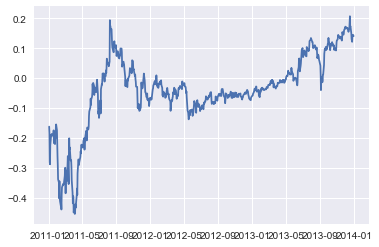

In [8]:
s1,w1 = coin_vec(SampleA.loc[:,['2y','3y']])
print('The cointegration vector for 2y and 3y is',w1)
_ = plt.plot(s1.index,s1)

### 3y, 4y cointegration

The cointegration vector for 3y and 4y is [-0.7987020090024662, 0.6017267659124234]


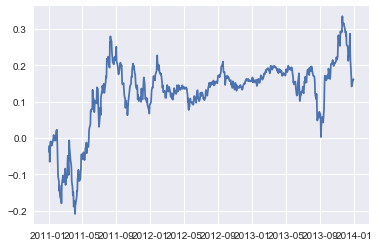

In [9]:
s2,w2 = coin_vec(SampleA.loc[:,['3y','4y']])
print('The cointegration vector for 3y and 4y is',w2)
_ = plt.plot(s2.index,s2)

### 4y, 5y cointegration

The cointegration vector for 4y and 5y is [-0.7482164424646854, 0.663454712264138]


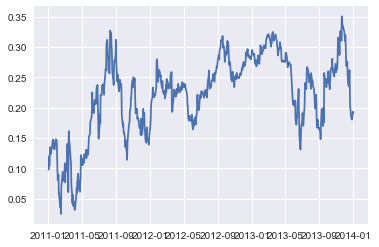

In [10]:
s3,w3 = coin_vec(SampleA.loc[:,['4y','5y']])
print('The cointegration vector for 4y and 5y is',w3)
_ = plt.plot(s3.index,s3)

### 2y, 4y cointegration

The cointegration vector for 2y and 4y is [-0.9256724678262124, 0.3783258943140557]


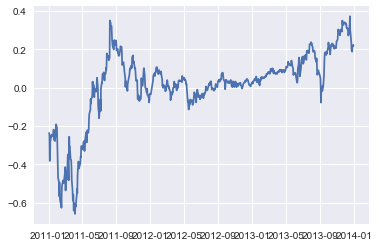

In [11]:
s4,w4 = coin_vec(SampleA.loc[:,['2y','4y']])
print('The cointegration vector for 2y and 4y is',w4)
_ = plt.plot(s4.index,s4)

### 3y, 5y cointegration

The cointegration vector for 3y and 5y is [-0.8305515457747055, 0.5569417651884687]


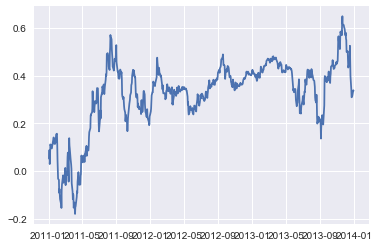

In [12]:
s5,w5 = coin_vec(SampleA.loc[:,['3y','5y']])
print('The cointegration vector for 3y and 5y is',w5)
_ = plt.plot(s5.index,s5)

## 2. Fit AR(1) Model

### a. Signal 1

In [13]:
def AR1(s):
    """Calculate AR(1) model parameters and the Half Life of mean reversion series.
    Methodology: https://quant.stackexchange.com/questions/25086/calculating-half-life-of-mean-reverting-series-with-python
    
    Args:
    s: pandas.Series
    
    Returns:
    Slope: float
    Intercept: float
    HF: float
    """
    
    x = s.shift()[1:] # Y(t-1)
    y = s.diff()[1:] # Y(t) - Y(t-1)
    x = sm.add_constant(x) #adds intercept terms to X variable for regression
    x.columns = ['const','x'] # Y(t) - Y(t-1) = intercept + slope *Y(t-1) + e
    param = sm.OLS(y,x).fit().params
    slope = param[1]
    HF = -math.log(2) / slope # Half-life = - log(2)/slope
    AR_param = [param[0],param[1]+1]
    
    return param[0],param[1]+1,HF

In [14]:
Intercept1, Slope1, HF1 = AR1(s1)
Intercept2, Slope2, HF2 = AR1(s2)
Intercept3, Slope3, HF3 = AR1(s3)
Intercept4, Slope4, HF4 = AR1(s4)
Intercept5, Slope5, HF5 = AR1(s5)

/Users/liunayan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [15]:
print('The slope and intercept parameters of AR(1) for 2y and 3y are:',np.round(Slope1,10),',',np.round(Intercept1,10))
print('The slope and intercept parameters of AR(1) for 3y and 4y are:',np.round(Slope2,10),',',np.round(Intercept2,10))
print('The slope and intercept parameters of AR(1) for 4y and 5y are:',np.round(Slope3,10),',',np.round(Intercept3,10))
print('The slope and intercept parameters of AR(1) for 2y and 4y are:',np.round(Slope4,10),',',np.round(Intercept4,10))
print('The slope and intercept parameters of AR(1) for 3y and 5y are:',np.round(Slope5,10),',',np.round(Intercept5,10))

The slope and intercept parameters of AR(1) for 2y and 3y are: 0.9899269734 , -3.0861e-06
The slope and intercept parameters of AR(1) for 3y and 4y are: 0.9870712229 , 0.0018845059
The slope and intercept parameters of AR(1) for 4y and 5y are: 0.9797219507 , 0.0046287373
The slope and intercept parameters of AR(1) for 2y and 4y are: 0.9896841617 , 0.0007438006
The slope and intercept parameters of AR(1) for 3y and 5y are: 0.9854357979 , 0.0050736839


### b. Signal 2: Pick $\lambda$ so that the Half-Life is 5 days

In [16]:
def optimize(series, target = 5):
    
    lam = np.arange(0.001,1.00,0.001)
    loss = np.array([])
    for i in lam:
        newseries = series - series.ewm(alpha = i).mean()
        HF = AR1(newseries)[2]
        loss = np.append(loss,abs(HF-target))
    lam0 = lam[loss.argmin()]
    newseries = series - series.ewm(alpha = lam0).mean()
    
    return lam0,newseries

In [17]:
lam1,s6 = optimize(s1)
lam2,s7 = optimize(s2)
lam3,s8 = optimize(s3)
lam4,s9 = optimize(s4)
lam5,s0 = optimize(s5)

In [18]:
Intercept6, Slope6, HF6 = AR1(s6)
Intercept7, Slope7, HF7 = AR1(s7)
Intercept8, Slope8, HF8 = AR1(s8)
Intercept9, Slope9, HF9 = AR1(s9)
Intercept0, Slope0, HF0 = AR1(s0)

In [19]:
print('The lambda for 2y and 3y in signal 2 is',np.round(lam1,3))
print('The lambda for 3y and 4y in signal 2 is',np.round(lam2,3))
print('The lambda for 4y and 5y in signal 2 is',np.round(lam3,3))
print('The lambda for 2y and 4y in signal 2 is',np.round(lam4,3))
print('The lambda for 3y and 5y in signal 2 is',np.round(lam5,3))

The lambda for 2y and 3y in signal 2 is 0.12
The lambda for 3y and 4y in signal 2 is 0.162
The lambda for 4y and 5y in signal 2 is 0.131
The lambda for 2y and 4y in signal 2 is 0.141
The lambda for 3y and 5y in signal 2 is 0.163


In [20]:
print('The slope and intercept parameters of AR(1) for 2y and 3y in signal 2 are:',np.round(Slope6,10),',',np.round(Intercept6,10))
print('The slope and intercept parameters of AR(1) for 3y and 4y in signal 2 are:',np.round(Slope7,10),',',np.round(Intercept7,10))
print('The slope and intercept parameters of AR(1) for 4y and 5y in signal 2 are:',np.round(Slope8,10),',',np.round(Intercept8,10))
print('The slope and intercept parameters of AR(1) for 2y and 4y in signal 2 are:',np.round(Slope9,10),',',np.round(Intercept9,10))
print('The slope and intercept parameters of AR(1) for 3y and 5y in signal 2 are:',np.round(Slope0,10),',',np.round(Intercept0,10))

The slope and intercept parameters of AR(1) for 2y and 3y in signal 2 are: 0.8617277097 , 0.0004737083
The slope and intercept parameters of AR(1) for 3y and 4y in signal 2 are: 0.8616253202 , 0.0001782238
The slope and intercept parameters of AR(1) for 4y and 5y in signal 2 are: 0.861112263 , 9.57319e-05
The slope and intercept parameters of AR(1) for 2y and 4y in signal 2 are: 0.8611435799 , 0.0005576057
The slope and intercept parameters of AR(1) for 3y and 5y in signal 2 are: 0.8610679683 , 0.0002426212


## 3. Compute Half-Life for all signal

In [21]:
print('The Half-Life for 2y and 3y signal 1 is',HF1)
print('The Half-Life for 3y and 4y signal 1 is',HF2)
print('The Half-Life for 4y and 5y signal 1 is',HF3)
print('The Half-Life for 2y and 4y signal 1 is',HF4)
print('The Half-Life for 3y and 5y signal 1 is',HF5)

The Half-Life for 2y and 3y signal 1 is 68.81220567020183
The Half-Life for 3y and 4y signal 1 is 53.61274133943241
The Half-Life for 4y and 5y signal 1 is 34.18214299530523
The Half-Life for 2y and 4y signal 1 is 67.19252091552303
The Half-Life for 3y and 5y signal 1 is 47.59252692707818


In [22]:
print('The Half-Life for 2y and 3y signal 2 is',np.round(HF6,2))
print('The Half-Life for 3y and 4y signal 2 is',np.round(HF7,2))
print('The Half-Life for 4y and 5y signal 2 is',np.round(HF8,2))
print('The Half-Life for 2y and 4y signal 2 is',np.round(HF9,2))
print('The Half-Life for 3y and 5y signal 2 is',np.round(HF0,2))

The Half-Life for 2y and 3y signal 2 is 5.01
The Half-Life for 3y and 4y signal 2 is 5.01
The Half-Life for 4y and 5y signal 2 is 4.99
The Half-Life for 2y and 4y signal 2 is 4.99
The Half-Life for 3y and 5y signal 2 is 4.99


## 4: Determine Optimal $\theta$ 
* The Metrics are correlation and RMSE.
* AR(1) Model for forecast:
$$y_{t+1} = \alpha+\beta \times y_{t} +\epsilon_t$$
$$E[y_{t+H}|t] = \alpha+\alpha \beta+\ldots+\alpha \beta^{H-1}+\beta^{H}y_{t} = \frac{\alpha(1-\beta^H)}{1-\beta}+\beta^{H}y_t$$

In [23]:
def forecast(series,alpha,beta,H=10):
    forecast = pd.Series(index = series.index)
    for i in range(len(series.index)-H):
        forecast[i+H] = (alpha*(1-beta**H))/(1-beta)+series[i]*beta**H
    combine = pd.DataFrame(index = series.index, columns = ['realized','predicted'])
    combine.iloc[:,0] = series
    combine.iloc[:,1] = forecast
    return combine

In [24]:
def correlation(data_set, threshold=0.001, H=10):
    data_set = data_set.loc[(abs(data_set.realized.shift(H) - data_set.predicted)>threshold),:]
    
    return data_set.corr().iloc[1,0]

In [25]:
def RMSE(data_set, threshold=0.001, H=10):
    data_set = data_set.loc[(abs(data_set.realized.shift(H) - data_set.predicted)>threshold),:]
    RMSE = np.sqrt(((data_set.realized.shift(10) - data_set.predicted)**2).sum()/len(data_set))
    return RMSE

### Signal 1 and 2 in Sample B

In [26]:
s1_B = SampleB.loc[:,'2y']*w1[0]+SampleB.loc[:,'3y']*w1[1]
s2_B = SampleB.loc[:,'3y']*w2[0]+SampleB.loc[:,'4y']*w2[1]
s3_B = SampleB.loc[:,'4y']*w3[0]+SampleB.loc[:,'5y']*w3[1]
s4_B = SampleB.loc[:,'2y']*w4[0]+SampleB.loc[:,'4y']*w4[1]
s5_B = SampleB.loc[:,'3y']*w5[0]+SampleB.loc[:,'5y']*w5[1]

In [27]:
s6_B = s1_B - s1_B.ewm(alpha = lam1).mean()
s7_B = s2_B - s2_B.ewm(alpha = lam2).mean()
s8_B = s3_B - s3_B.ewm(alpha = lam3).mean()
s9_B = s4_B - s4_B.ewm(alpha = lam4).mean()
s0_B = s5_B - s5_B.ewm(alpha = lam5).mean()

### Determine $\theta$
* Define $Signal 3 = Signal 1 + \theta \times Signal 2$, and we use Sample B to determine the best $\theta$. And we choose RMSE as quality metrics.

In [28]:
def signal3(data_set1,data_set2,theta):
    data_set3 = data_set1+theta*data_set2
    return data_set3

In [29]:
d1 = forecast(s1_B,Intercept1,Slope1)
d2 = forecast(s6_B,Intercept6,Slope6)
RMSE(signal3(d1, d2,0.1))

0.039528193808558834

In [30]:
def optimize2(data_set1,data_set2):
    
    theta = np.arange(0.001,1.00,0.001)
    loss = np.array([])
    for i in theta:
        newseries = signal3(data_set1,data_set2,i)
        loss = np.append(loss, RMSE(newseries))
    theta0 = theta[loss.argmin()]
    newseries = signal3(data_set1,data_set2,theta0)
    
    return theta0, newseries

In [31]:
theta1, s31_B = optimize2(forecast(s1_B,Intercept1,Slope1),forecast(s6_B,Intercept6,Slope6))
theta2, s32_B = optimize2(forecast(s2_B,Intercept2,Slope2),forecast(s7_B,Intercept7,Slope7))
theta3, s33_B = optimize2(forecast(s3_B,Intercept3,Slope3),forecast(s8_B,Intercept8,Slope8))
theta4, s34_B = optimize2(forecast(s4_B,Intercept4,Slope4),forecast(s9_B,Intercept9,Slope9))
theta5, s35_B = optimize2(forecast(s5_B,Intercept5,Slope5),forecast(s0_B,Intercept0,Slope0))

In [32]:
print('The optimal theta for 2y and 3y signal 3 is',theta1)
print('The optimal theta for 3y and 4y signal 3 is',theta2)
print('The optimal theta for 4y and 5y signal 3 is',theta3)
print('The optimal theta for 2y and 4y signal 3 is',theta4)
print('The optimal theta for 3y and 5y signal 3 is',theta5)

The optimal theta for 2y and 3y signal 3 is 0.002
The optimal theta for 3y and 4y signal 3 is 0.001
The optimal theta for 4y and 5y signal 3 is 0.001
The optimal theta for 2y and 4y signal 3 is 0.005
The optimal theta for 3y and 5y signal 3 is 0.085


## 5. Signal Quality Analysis in Sample B

In [33]:
def predict_plot(data_set, tl):
    _ = plt.figure(figsize = (20,5))
    _ = plt.plot(data_set)
    _ = plt.legend(['Realized','predicted'])
    _ = plt.title(tl)

### Signal 1

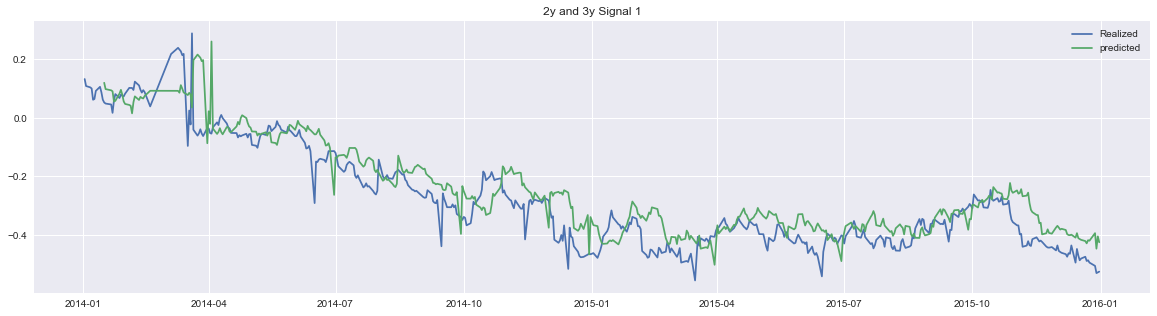

In [34]:
predict_plot(forecast(s1_B,Intercept1,Slope1),'2y and 3y Signal 1')

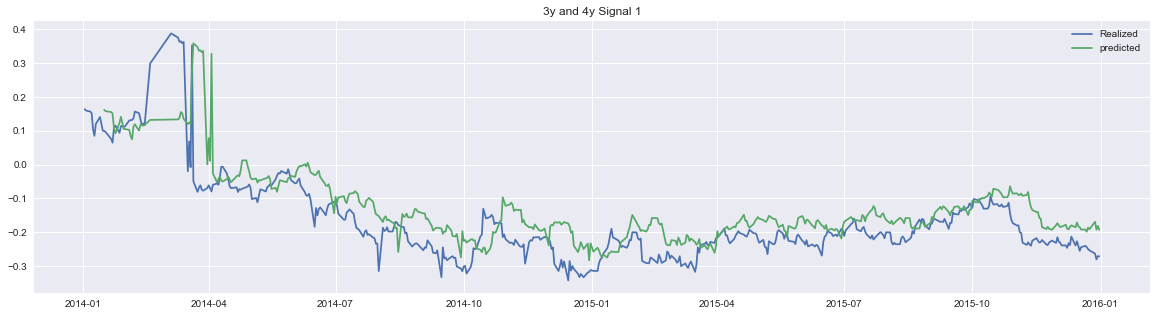

In [35]:
predict_plot(forecast(s2_B,Intercept2,Slope2),'3y and 4y Signal 1')

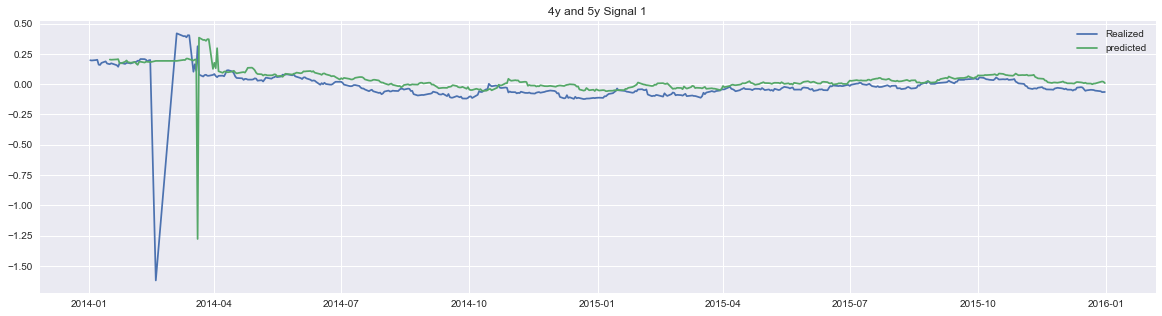

In [36]:
predict_plot(forecast(s3_B,Intercept3,Slope3),'4y and 5y Signal 1')

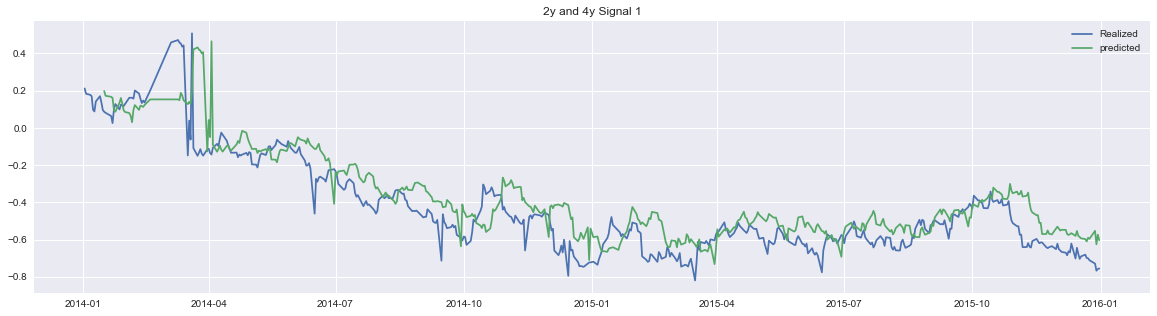

In [37]:
predict_plot(forecast(s4_B,Intercept4,Slope4),'2y and 4y Signal 1')

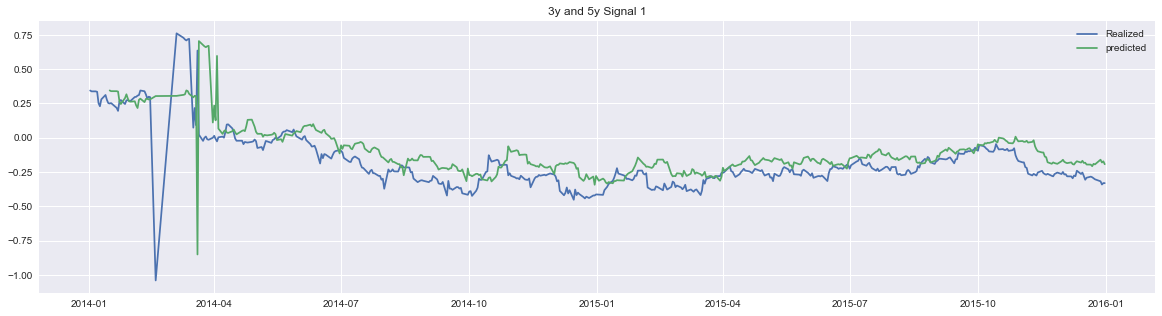

In [38]:
predict_plot(forecast(s5_B,Intercept5,Slope5),'3y and 5y Signal 1')

In [39]:
print('The correlation of predicted and realized for 2y and 3y Signal 1 is',np.round(correlation(forecast(s1_B,Intercept1,Slope1)),2))
print('The correlation of predicted and realized for 2y and 3y Signal 1 is',np.round(correlation(forecast(s2_B,Intercept2,Slope2)),2))
print('The correlation of predicted and realized for 2y and 3y Signal 1 is',np.round(correlation(forecast(s3_B,Intercept3,Slope3)),2))
print('The correlation of predicted and realized for 2y and 3y Signal 1 is',np.round(correlation(forecast(s4_B,Intercept4,Slope4)),2))
print('The correlation of predicted and realized for 2y and 3y Signal 1 is',np.round(correlation(forecast(s5_B,Intercept5,Slope5)),2))

The correlation of predicted and realized for 2y and 3y Signal 1 is 0.91
The correlation of predicted and realized for 2y and 3y Signal 1 is 0.8
The correlation of predicted and realized for 2y and 3y Signal 1 is 0.31
The correlation of predicted and realized for 2y and 3y Signal 1 is 0.88
The correlation of predicted and realized for 2y and 3y Signal 1 is 0.69


In [40]:
print('The RMSE of predicted and realized for 2y and 3y Signal 1 is',np.round(RMSE(forecast(s1_B,Intercept1,Slope1)),5))
print('The RMSE of predicted and realized for 2y and 3y Signal 1 is',np.round(RMSE(forecast(s2_B,Intercept2,Slope2)),5))
print('The RMSE of predicted and realized for 2y and 3y Signal 1 is',np.round(RMSE(forecast(s3_B,Intercept3,Slope3)),5))
print('The RMSE of predicted and realized for 2y and 3y Signal 1 is',np.round(RMSE(forecast(s4_B,Intercept4,Slope4)),5))
print('The RMSE of predicted and realized for 2y and 3y Signal 1 is',np.round(RMSE(forecast(s5_B,Intercept5,Slope5)),5))

The RMSE of predicted and realized for 2y and 3y Signal 1 is 0.03156
The RMSE of predicted and realized for 2y and 3y Signal 1 is 0.04193
The RMSE of predicted and realized for 2y and 3y Signal 1 is 0.04912
The RMSE of predicted and realized for 2y and 3y Signal 1 is 0.05566
The RMSE of predicted and realized for 2y and 3y Signal 1 is 0.12218


### Signal 2

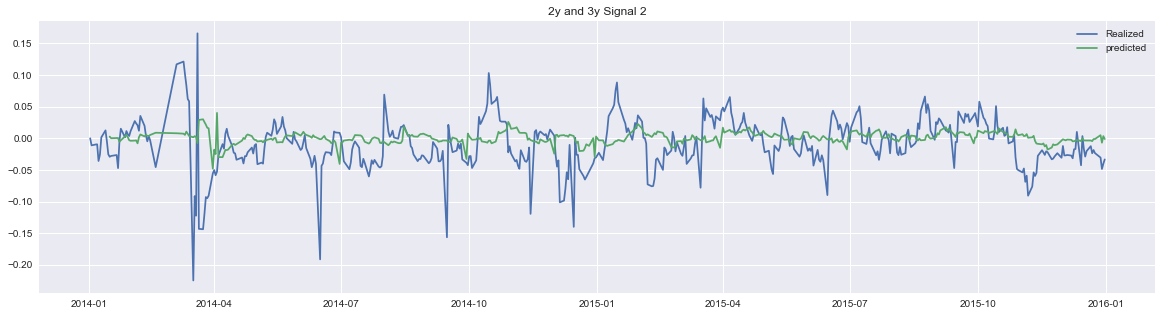

In [41]:
predict_plot(forecast(s6_B,Intercept6,Slope6),'2y and 3y Signal 2')

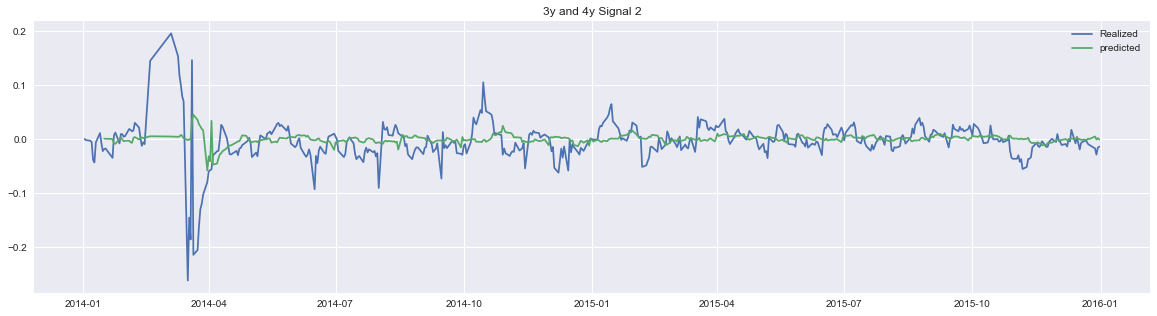

In [42]:
predict_plot(forecast(s7_B,Intercept7,Slope7),'3y and 4y Signal 2')

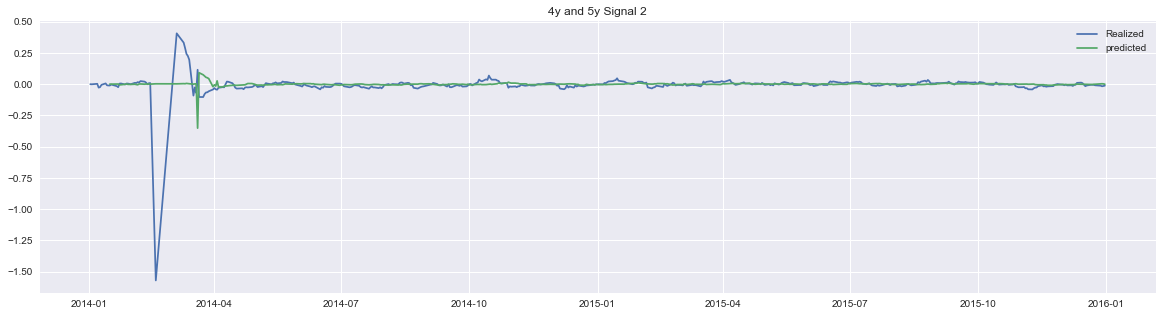

In [43]:
predict_plot(forecast(s8_B,Intercept8,Slope8),'4y and 5y Signal 2')

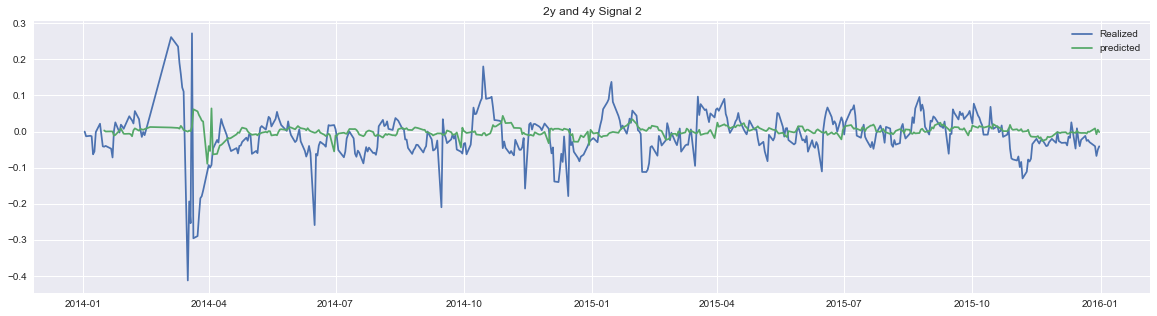

In [44]:
predict_plot(forecast(s9_B,Intercept9,Slope9),'2y and 4y Signal 2')

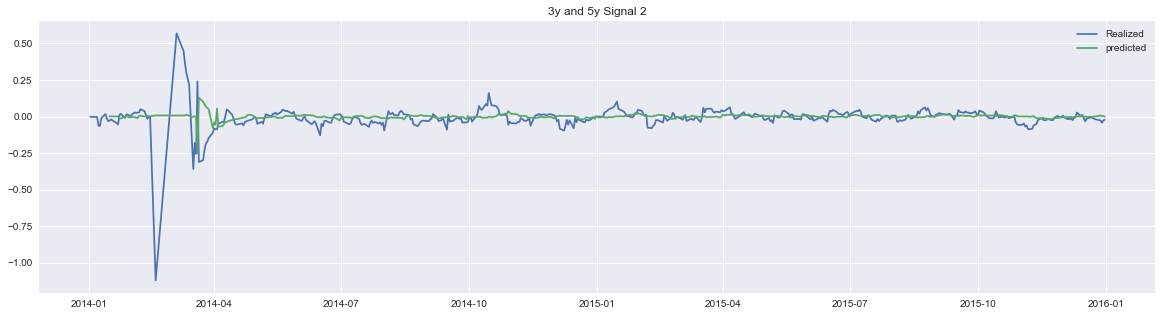

In [45]:
predict_plot(forecast(s0_B,Intercept0,Slope0),'3y and 5y Signal 2')

In [46]:
print('The correlation of predicted and realized for 2y and 3y Signal 2 is',np.round(correlation(forecast(s6_B,Intercept6,Slope6)),2))
print('The correlation of predicted and realized for 3y and 4y Signal 2 is',np.round(correlation(forecast(s7_B,Intercept7,Slope7)),2))
print('The correlation of predicted and realized for 4y and 5y Signal 2 is',np.round(correlation(forecast(s8_B,Intercept8,Slope8)),2))
print('The correlation of predicted and realized for 2y and 4y Signal 2 is',np.round(correlation(forecast(s9_B,Intercept9,Slope9)),2))
print('The correlation of predicted and realized for 3y and 5y Signal 2 is',np.round(correlation(forecast(s0_B,Intercept0,Slope0)),2))

The correlation of predicted and realized for 2y and 3y Signal 2 is 0.01
The correlation of predicted and realized for 3y and 4y Signal 2 is -0.06
The correlation of predicted and realized for 4y and 5y Signal 2 is -0.09
The correlation of predicted and realized for 2y and 4y Signal 2 is -0.03
The correlation of predicted and realized for 3y and 5y Signal 2 is -0.2


In [47]:
print('The RMSE of predicted and realized for 2y and 3y Signal 2 is',np.round(RMSE(forecast(s6_B,Intercept6,Slope6)),5))
print('The RMSE of predicted and realized for 3y and 4y Signal 2 is',np.round(RMSE(forecast(s7_B,Intercept7,Slope7)),5))
print('The RMSE of predicted and realized for 4y and 5y Signal 2 is',np.round(RMSE(forecast(s8_B,Intercept8,Slope8)),5))
print('The RMSE of predicted and realized for 2y and 4y Signal 2 is',np.round(RMSE(forecast(s9_B,Intercept9,Slope9)),5))
print('The RMSE of predicted and realized for 3y and 5y Signal 2 is',np.round(RMSE(forecast(s0_B,Intercept0,Slope0)),5))

The RMSE of predicted and realized for 2y and 3y Signal 2 is 0.03355
The RMSE of predicted and realized for 3y and 4y Signal 2 is 0.02973
The RMSE of predicted and realized for 4y and 5y Signal 2 is 0.06488
The RMSE of predicted and realized for 2y and 4y Signal 2 is 0.05145
The RMSE of predicted and realized for 3y and 5y Signal 2 is 0.06511


### Signal 3

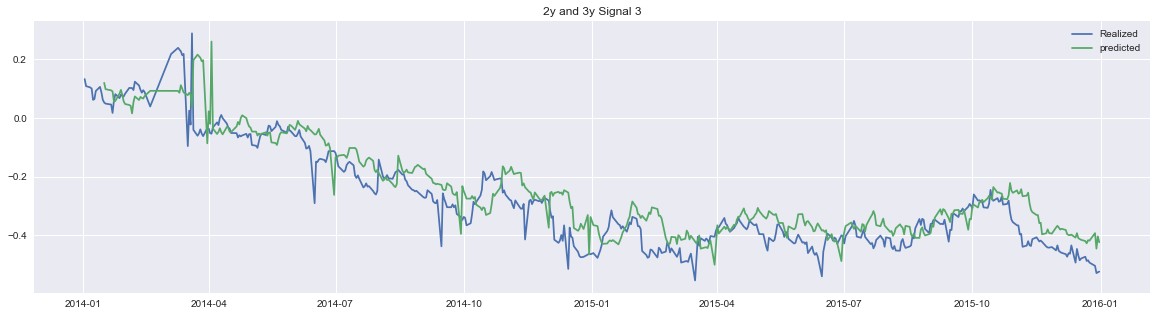

In [48]:
predict_plot(s31_B,'2y and 3y Signal 3')

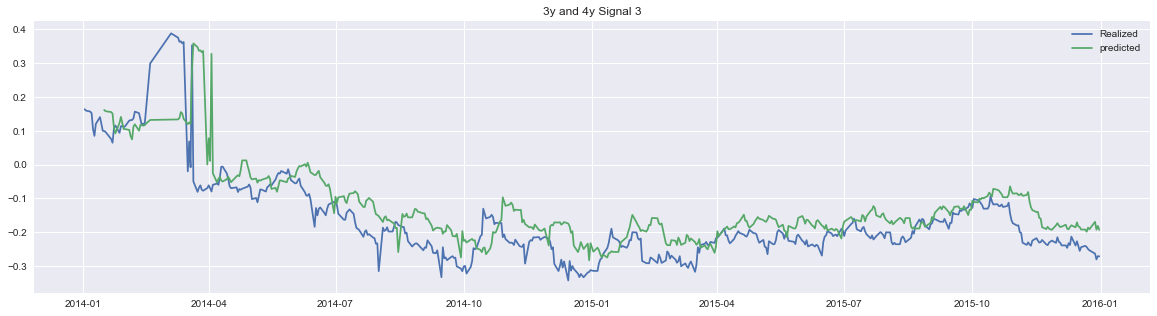

In [49]:
predict_plot(s32_B,'3y and 4y Signal 3')

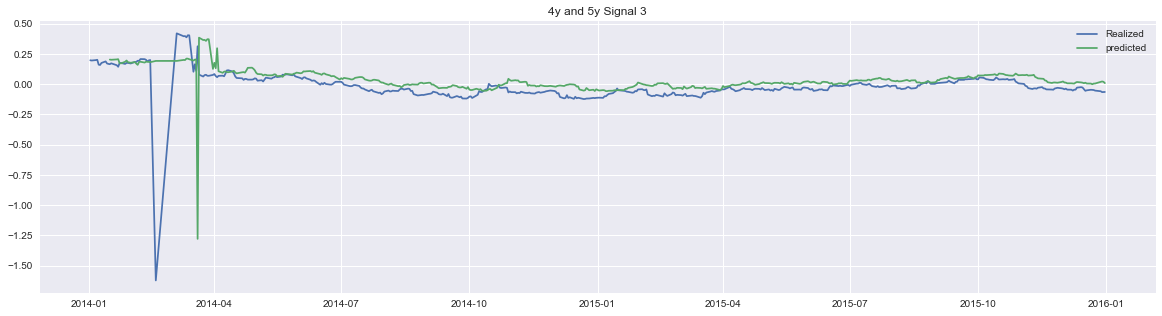

In [50]:
predict_plot(s33_B,'4y and 5y Signal 3')

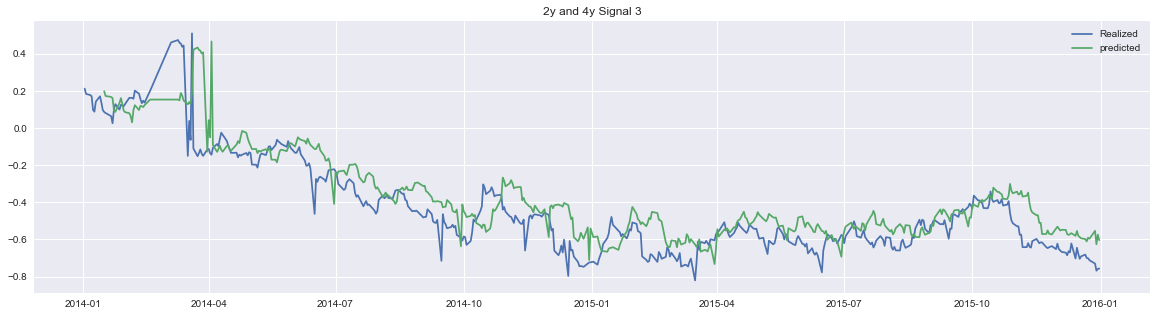

In [51]:
predict_plot(s34_B,'2y and 4y Signal 3')

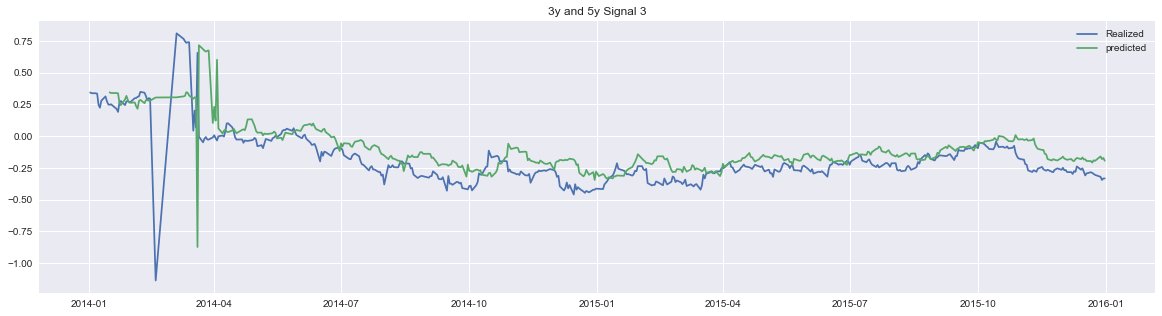

In [52]:
predict_plot(s35_B,'3y and 5y Signal 3')

In [53]:
print('The correlation of predicted and realized for 2y and 3y Signal 3 is',np.round(correlation(s31_B),2))
print('The correlation of predicted and realized for 3y and 4y Signal 3 is',np.round(correlation(s32_B),2))
print('The correlation of predicted and realized for 4y and 5y Signal 3 is',np.round(correlation(s33_B),2))
print('The correlation of predicted and realized for 2y and 4y Signal 3 is',np.round(correlation(s34_B),2))
print('The correlation of predicted and realized for 3y and 5y Signal 3 is',np.round(correlation(s35_B),2))

The correlation of predicted and realized for 2y and 3y Signal 3 is 0.91
The correlation of predicted and realized for 3y and 4y Signal 3 is 0.8
The correlation of predicted and realized for 4y and 5y Signal 3 is 0.31
The correlation of predicted and realized for 2y and 4y Signal 3 is 0.88
The correlation of predicted and realized for 3y and 5y Signal 3 is 0.67


In [54]:
print('The RMSE of predicted and realized for 2y and 3y Signal 3 is',np.round(RMSE(s31_B),5))
print('The RMSE of predicted and realized for 3y and 4y Signal 3 is',np.round(RMSE(s32_B),5))
print('The RMSE of predicted and realized for 4y and 5y Signal 3 is',np.round(RMSE(s33_B),5))
print('The RMSE of predicted and realized for 2y and 4y Signal 3 is',np.round(RMSE(s34_B),5))
print('The RMSE of predicted and realized for 3y and 5y Signal 3 is',np.round(RMSE(s35_B),5))

The RMSE of predicted and realized for 2y and 3y Signal 3 is 0.03154
The RMSE of predicted and realized for 3y and 4y Signal 3 is 0.04193
The RMSE of predicted and realized for 4y and 5y Signal 3 is 0.04915
The RMSE of predicted and realized for 2y and 4y Signal 3 is 0.05555
The RMSE of predicted and realized for 3y and 5y Signal 3 is 0.07819


## 6. Signal Quality Analysis in Sample C

In [55]:
q1 = ['2016-01-01','2016-03-31']
q2 = ['2016-04-01','2016-06-30']
q3 = ['2016-07-01','2016-09-30']
q4 = ['2016-10-01','2016-12-31']

### Signal 1

In [56]:
s1_C = SampleC.loc[:,'2y']*w1[0]+SampleC.loc[:,'3y']*w1[1]
s2_C = SampleC.loc[:,'3y']*w2[0]+SampleC.loc[:,'4y']*w2[1]
s3_C = SampleC.loc[:,'4y']*w3[0]+SampleC.loc[:,'5y']*w3[1]
s4_C = SampleC.loc[:,'2y']*w4[0]+SampleC.loc[:,'4y']*w4[1]
s5_C = SampleC.loc[:,'3y']*w5[0]+SampleC.loc[:,'5y']*w5[1]

#### Realized vs Predicted

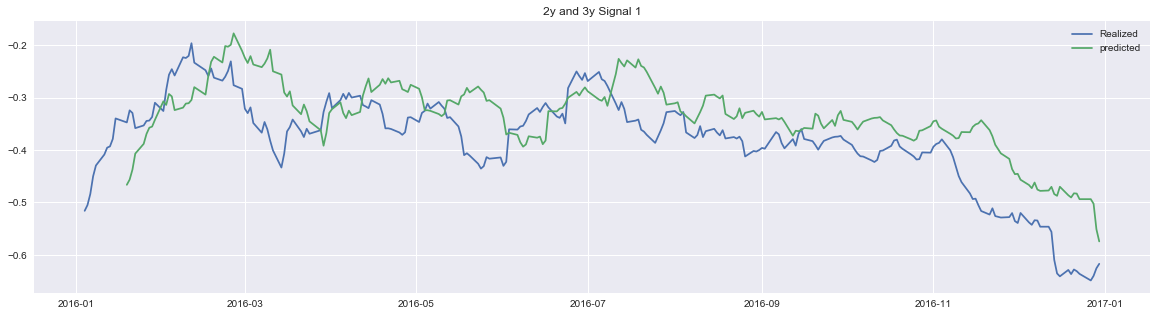

In [57]:
predict_plot(forecast(s1_C,Intercept1,Slope1),'2y and 3y Signal 1')

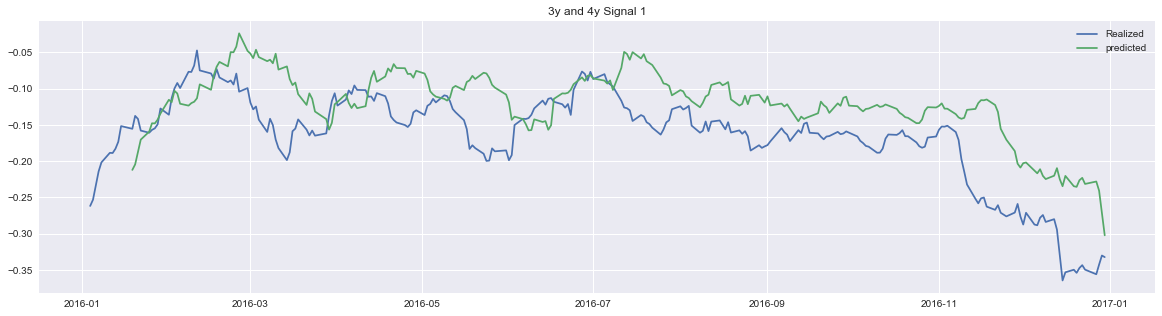

In [58]:
predict_plot(forecast(s2_C,Intercept2,Slope2),'3y and 4y Signal 1')

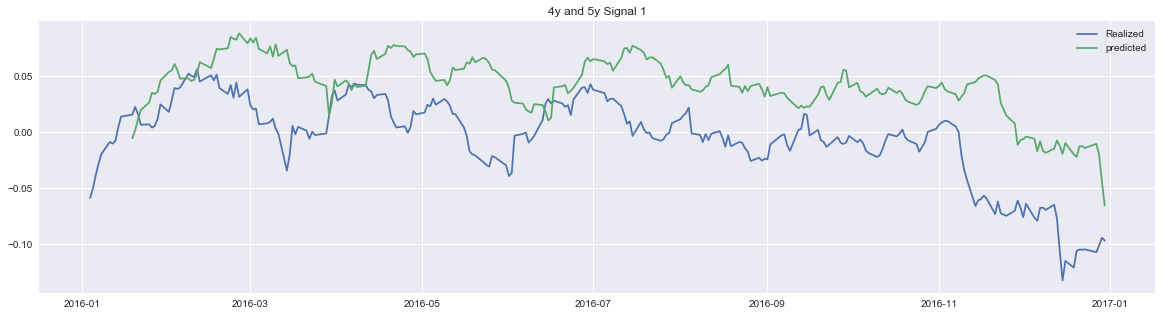

In [59]:
predict_plot(forecast(s3_C,Intercept3,Slope3),'4y and 5y Signal 1')

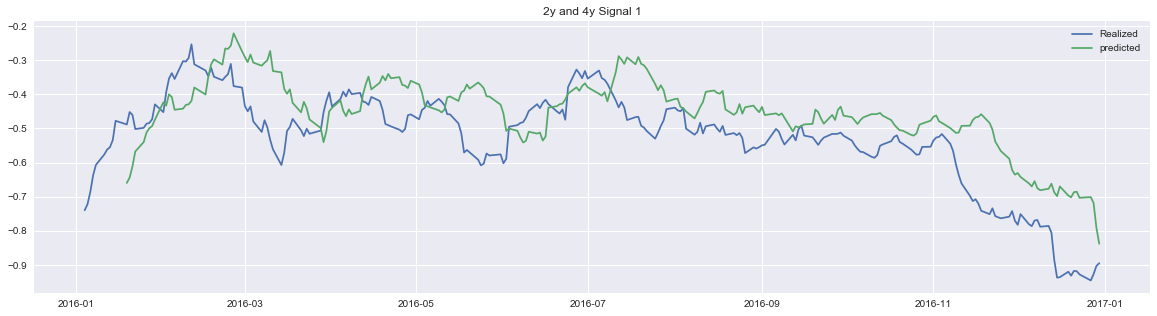

In [60]:
predict_plot(forecast(s4_C,Intercept4,Slope4),'2y and 4y Signal 1')

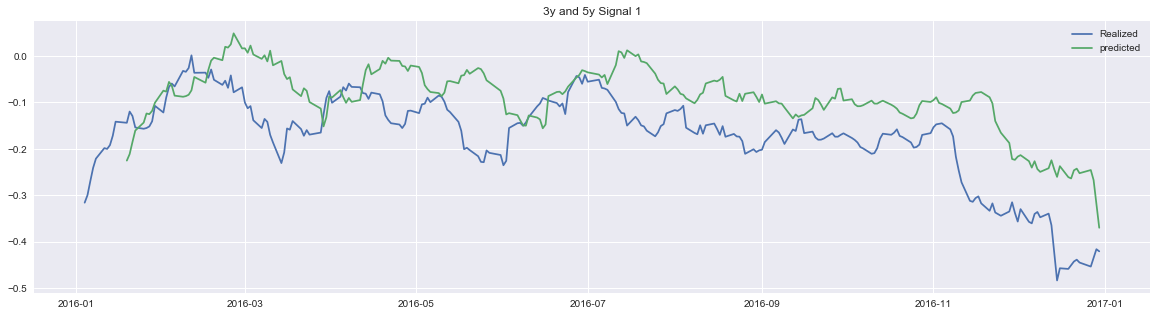

In [61]:
predict_plot(forecast(s5_C,Intercept5,Slope5),'3y and 5y Signal 1')

#### Correlation in 4 quarters

In [62]:
print('The correlation of predicted and realized for 2y and 3y Signal 1 in quarter 1 is',np.round(correlation(forecast(s1_C[q1[0]:q1[1]],Intercept1,Slope1)),2))
print('The correlation of predicted and realized for 3y and 4y Signal 1 in quarter 1 is',np.round(correlation(forecast(s2_C[q1[0]:q1[1]],Intercept2,Slope2)),2))
print('The correlation of predicted and realized for 4y and 5y Signal 1 in quarter 1 is',np.round(correlation(forecast(s3_C[q1[0]:q1[1]],Intercept3,Slope3)),2))
print('The correlation of predicted and realized for 2y and 4y Signal 1 in quarter 1 is',np.round(correlation(forecast(s4_C[q1[0]:q1[1]],Intercept4,Slope4)),2))
print('The correlation of predicted and realized for 3y and 5y Signal 1 in quarter 1 is',np.round(correlation(forecast(s5_C[q1[0]:q1[1]],Intercept5,Slope5)),2))

The correlation of predicted and realized for 2y and 3y Signal 1 in quarter 1 is 0.2
The correlation of predicted and realized for 3y and 4y Signal 1 in quarter 1 is 0.21
The correlation of predicted and realized for 4y and 5y Signal 1 in quarter 1 is 0.14
The correlation of predicted and realized for 2y and 4y Signal 1 in quarter 1 is 0.21
The correlation of predicted and realized for 3y and 5y Signal 1 in quarter 1 is 0.19


In [63]:
print('The correlation of predicted and realized for 2y and 3y Signal 1 in quarter 2 is',np.round(correlation(forecast(s1_C[q2[0]:q2[1]],Intercept1,Slope1)),2))
print('The correlation of predicted and realized for 3y and 4y Signal 1 in quarter 2 is',np.round(correlation(forecast(s2_C[q2[0]:q2[1]],Intercept2,Slope2)),2))
print('The correlation of predicted and realized for 4y and 5y Signal 1 in quarter 2 is',np.round(correlation(forecast(s3_C[q2[0]:q2[1]],Intercept3,Slope3)),2))
print('The correlation of predicted and realized for 2y and 4y Signal 1 in quarter 2 is',np.round(correlation(forecast(s4_C[q2[0]:q2[1]],Intercept4,Slope4)),2))
print('The correlation of predicted and realized for 3y and 5y Signal 1 in quarter 2 is',np.round(correlation(forecast(s5_C[q2[0]:q2[1]],Intercept5,Slope5)),2))

The correlation of predicted and realized for 2y and 3y Signal 1 in quarter 2 is -0.06
The correlation of predicted and realized for 3y and 4y Signal 1 in quarter 2 is -0.08
The correlation of predicted and realized for 4y and 5y Signal 1 in quarter 2 is 0.02
The correlation of predicted and realized for 2y and 4y Signal 1 in quarter 2 is -0.07
The correlation of predicted and realized for 3y and 5y Signal 1 in quarter 2 is -0.04


In [64]:
print('The correlation of predicted and realized for 2y and 3y Signal 1 in quarter 3 is',np.round(correlation(forecast(s1_C[q3[0]:q3[1]],Intercept1,Slope1)),2))
print('The correlation of predicted and realized for 3y and 4y Signal 1 in quarter 3 is',np.round(correlation(forecast(s2_C[q3[0]:q3[1]],Intercept2,Slope2)),2))
print('The correlation of predicted and realized for 4y and 5y Signal 1 in quarter 3 is',np.round(correlation(forecast(s3_C[q3[0]:q3[1]],Intercept3,Slope3)),2))
print('The correlation of predicted and realized for 2y and 4y Signal 1 in quarter 3 is',np.round(correlation(forecast(s4_C[q3[0]:q3[1]],Intercept4,Slope4)),2))
print('The correlation of predicted and realized for 3y and 5y Signal 1 in quarter 3 is',np.round(correlation(forecast(s5_C[q3[0]:q3[1]],Intercept5,Slope5)),2))

The correlation of predicted and realized for 2y and 3y Signal 1 in quarter 3 is 0.4
The correlation of predicted and realized for 3y and 4y Signal 1 in quarter 3 is 0.38
The correlation of predicted and realized for 4y and 5y Signal 1 in quarter 3 is 0.06
The correlation of predicted and realized for 2y and 4y Signal 1 in quarter 3 is 0.4
The correlation of predicted and realized for 3y and 5y Signal 1 in quarter 3 is 0.27


In [65]:
print('The correlation of predicted and realized for 2y and 3y Signal 1 in quarter 4 is',np.round(correlation(forecast(s1_C[q4[0]:q4[1]],Intercept1,Slope1)),2))
print('The correlation of predicted and realized for 3y and 4y Signal 1 in quarter 4 is',np.round(correlation(forecast(s2_C[q4[0]:q4[1]],Intercept2,Slope2)),2))
print('The correlation of predicted and realized for 4y and 5y Signal 1 in quarter 4 is',np.round(correlation(forecast(s3_C[q4[0]:q4[1]],Intercept3,Slope3)),2))
print('The correlation of predicted and realized for 2y and 4y Signal 1 in quarter 4 is',np.round(correlation(forecast(s4_C[q4[0]:q4[1]],Intercept4,Slope4)),2))
print('The correlation of predicted and realized for 3y and 5y Signal 1 in quarter 4 is',np.round(correlation(forecast(s5_C[q4[0]:q4[1]],Intercept5,Slope5)),2))

The correlation of predicted and realized for 2y and 3y Signal 1 in quarter 4 is 0.85
The correlation of predicted and realized for 3y and 4y Signal 1 in quarter 4 is 0.82
The correlation of predicted and realized for 4y and 5y Signal 1 in quarter 4 is 0.72
The correlation of predicted and realized for 2y and 4y Signal 1 in quarter 4 is 0.85
The correlation of predicted and realized for 3y and 5y Signal 1 in quarter 4 is 0.79


#### RMSE in 4 quarters

In [66]:
print('The RMSE of predicted and realized for 2y and 3y Signal 1 in quarter 1 is',np.round(RMSE(forecast(s1_C[q1[0]:q1[1]],Intercept1,Slope1)),5))
print('The RMSE of predicted and realized for 3y and 4y Signal 1 in quarter 1 is',np.round(RMSE(forecast(s2_C[q1[0]:q1[1]],Intercept2,Slope2)),5))
print('The RMSE of predicted and realized for 4y and 5y Signal 1 in quarter 1 is',np.round(RMSE(forecast(s3_C[q1[0]:q1[1]],Intercept3,Slope3)),5))
print('The RMSE of predicted and realized for 2y and 4y Signal 1 in quarter 1 is',np.round(RMSE(forecast(s4_C[q1[0]:q1[1]],Intercept4,Slope4)),5))
print('The RMSE of predicted and realized for 3y and 5y Signal 1 in quarter 1 is',np.round(RMSE(forecast(s5_C[q1[0]:q1[1]],Intercept5,Slope5)),5))

The RMSE of predicted and realized for 2y and 3y Signal 1 in quarter 1 is 0.02671
The RMSE of predicted and realized for 3y and 4y Signal 1 in quarter 1 is 0.02949
The RMSE of predicted and realized for 4y and 5y Signal 1 in quarter 1 is 0.03409
The RMSE of predicted and realized for 2y and 4y Signal 1 in quarter 1 is 0.04402
The RMSE of predicted and realized for 3y and 5y Signal 1 in quarter 1 is 0.05548


In [67]:
print('The RMSE of predicted and realized for 2y and 3y Signal 1 in quarter 2 is',np.round(RMSE(forecast(s1_C[q2[0]:q2[1]],Intercept1,Slope1)),5))
print('The RMSE of predicted and realized for 3y and 4y Signal 1 in quarter 2 is',np.round(RMSE(forecast(s2_C[q1[0]:q1[1]],Intercept2,Slope2)),5))
print('The RMSE of predicted and realized for 4y and 5y Signal 1 in quarter 2 is',np.round(RMSE(forecast(s3_C[q1[0]:q1[1]],Intercept3,Slope3)),5))
print('The RMSE of predicted and realized for 2y and 4y Signal 1 in quarter 2 is',np.round(RMSE(forecast(s4_C[q1[0]:q1[1]],Intercept4,Slope4)),5))
print('The RMSE of predicted and realized for 3y and 5y Signal 1 in quarter 2 is',np.round(RMSE(forecast(s5_C[q1[0]:q1[1]],Intercept5,Slope5)),5))

The RMSE of predicted and realized for 2y and 3y Signal 1 in quarter 2 is 0.03134
The RMSE of predicted and realized for 3y and 4y Signal 1 in quarter 2 is 0.02949
The RMSE of predicted and realized for 4y and 5y Signal 1 in quarter 2 is 0.03409
The RMSE of predicted and realized for 2y and 4y Signal 1 in quarter 2 is 0.04402
The RMSE of predicted and realized for 3y and 5y Signal 1 in quarter 2 is 0.05548


In [68]:
print('The RMSE of predicted and realized for 2y and 3y Signal 1 in quarter 3 is',np.round(RMSE(forecast(s1_C[q3[0]:q3[1]],Intercept1,Slope1)),5))
print('The RMSE of predicted and realized for 3y and 4y Signal 1 in quarter 3 is',np.round(RMSE(forecast(s2_C[q3[0]:q3[1]],Intercept2,Slope2)),5))
print('The RMSE of predicted and realized for 4y and 5y Signal 1 in quarter 3 is',np.round(RMSE(forecast(s3_C[q3[0]:q3[1]],Intercept3,Slope3)),5))
print('The RMSE of predicted and realized for 2y and 4y Signal 1 in quarter 3 is',np.round(RMSE(forecast(s4_C[q3[0]:q3[1]],Intercept4,Slope4)),5))
print('The RMSE of predicted and realized for 3y and 5y Signal 1 in quarter 3 is',np.round(RMSE(forecast(s5_C[q3[0]:q3[1]],Intercept5,Slope5)),5))

The RMSE of predicted and realized for 2y and 3y Signal 1 in quarter 3 is 0.03215
The RMSE of predicted and realized for 3y and 4y Signal 1 in quarter 3 is 0.03308
The RMSE of predicted and realized for 4y and 5y Signal 1 in quarter 3 is 0.03891
The RMSE of predicted and realized for 2y and 4y Signal 1 in quarter 3 is 0.0515
The RMSE of predicted and realized for 3y and 5y Signal 1 in quarter 3 is 0.06274


In [69]:
print('The RMSE of predicted and realized for 2y and 3y Signal 1 in quarter 4 is',np.round(RMSE(forecast(s1_C[q4[0]:q4[1]],Intercept1,Slope1)),5))
print('The RMSE of predicted and realized for 3y and 4y Signal 1 in quarter 4 is',np.round(RMSE(forecast(s2_C[q4[0]:q4[1]],Intercept2,Slope2)),5))
print('The RMSE of predicted and realized for 4y and 5y Signal 1 in quarter 4 is',np.round(RMSE(forecast(s3_C[q4[0]:q4[1]],Intercept3,Slope3)),5))
print('The RMSE of predicted and realized for 2y and 4y Signal 1 in quarter 4 is',np.round(RMSE(forecast(s4_C[q4[0]:q4[1]],Intercept4,Slope4)),5))
print('The RMSE of predicted and realized for 3y and 5y Signal 1 in quarter 4 is',np.round(RMSE(forecast(s5_C[q4[0]:q4[1]],Intercept5,Slope5)),5))

The RMSE of predicted and realized for 2y and 3y Signal 1 in quarter 4 is 0.04152
The RMSE of predicted and realized for 3y and 4y Signal 1 in quarter 4 is 0.04166
The RMSE of predicted and realized for 4y and 5y Signal 1 in quarter 4 is 0.04542
The RMSE of predicted and realized for 2y and 4y Signal 1 in quarter 4 is 0.06676
The RMSE of predicted and realized for 3y and 5y Signal 1 in quarter 4 is 0.07654


### Signal 2

In [70]:
s6_C = s1_C - s1_C.ewm(alpha = lam1).mean()
s7_C = s2_C - s2_C.ewm(alpha = lam2).mean()
s8_C = s3_C - s3_C.ewm(alpha = lam3).mean()
s9_C = s4_C - s4_C.ewm(alpha = lam4).mean()
s0_C = s5_C - s5_C.ewm(alpha = lam5).mean()

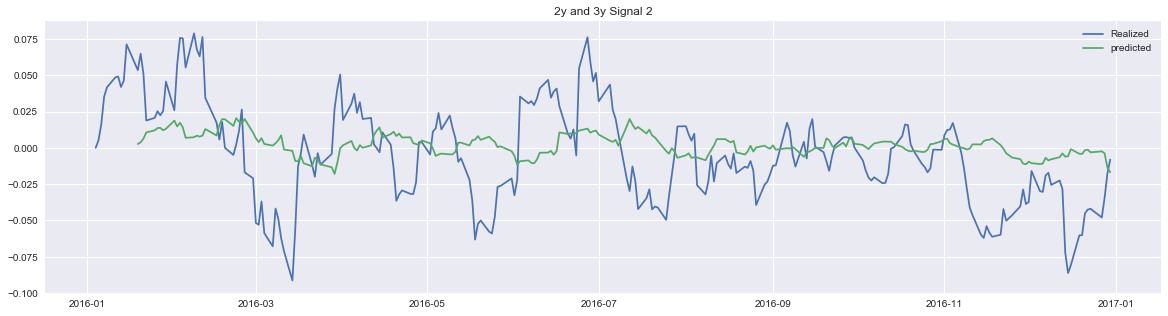

In [71]:
predict_plot(forecast(s6_C,Intercept6,Slope6),'2y and 3y Signal 2')

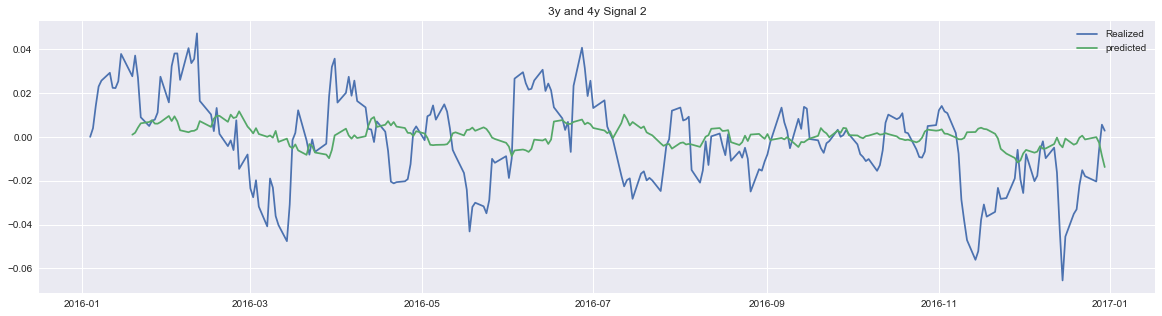

In [72]:
predict_plot(forecast(s7_C,Intercept7,Slope7),'3y and 4y Signal 2')

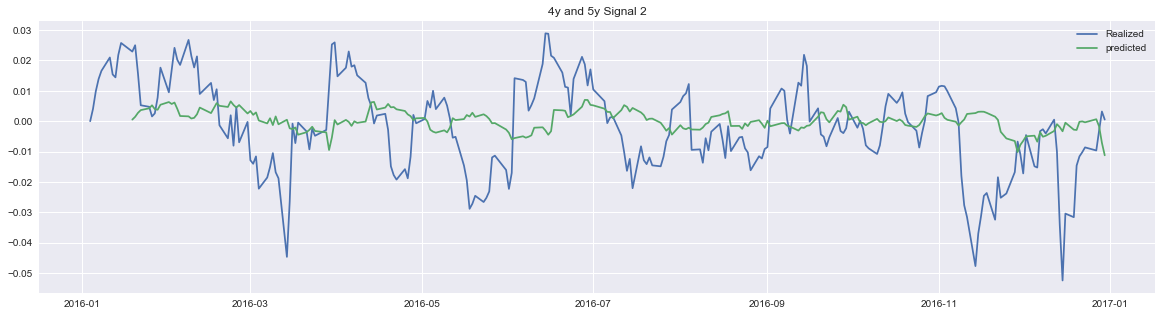

In [73]:
predict_plot(forecast(s8_C,Intercept8,Slope8),'4y and 5y Signal 2')

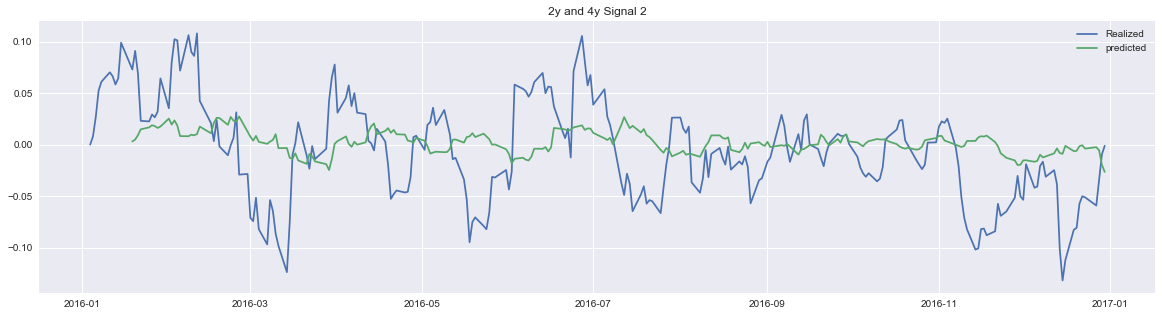

In [74]:
predict_plot(forecast(s9_C,Intercept9,Slope9),'2y and 4y Signal 2')

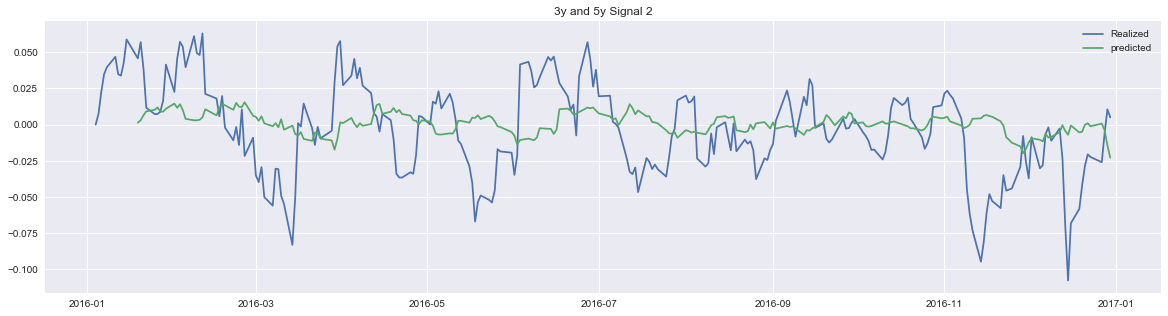

In [75]:
predict_plot(forecast(s0_C,Intercept0,Slope0),'3y and 5y Signal 2')

#### Correlation in 4 quarters

In [76]:
print('The correlation of predicted and realized for 2y and 3y Signal 2 in quarter 1 is',np.round(correlation(forecast(s6_C[q1[0]:q1[1]],Intercept6,Slope6)),2))
print('The correlation of predicted and realized for 3y and 4y Signal 2 in quarter 1 is',np.round(correlation(forecast(s7_C[q1[0]:q1[1]],Intercept7,Slope7)),2))
print('The correlation of predicted and realized for 4y and 5y Signal 2 in quarter 1 is',np.round(correlation(forecast(s8_C[q1[0]:q1[1]],Intercept8,Slope8)),2))
print('The correlation of predicted and realized for 2y and 4y Signal 2 in quarter 1 is',np.round(correlation(forecast(s9_C[q1[0]:q1[1]],Intercept9,Slope9)),2))
print('The correlation of predicted and realized for 3y and 5y Signal 2 in quarter 1 is',np.round(correlation(forecast(s0_C[q1[0]:q1[1]],Intercept0,Slope0)),2))

The correlation of predicted and realized for 2y and 3y Signal 2 in quarter 1 is 0.28
The correlation of predicted and realized for 3y and 4y Signal 2 in quarter 1 is 0.2
The correlation of predicted and realized for 4y and 5y Signal 2 in quarter 1 is 0.2
The correlation of predicted and realized for 2y and 4y Signal 2 in quarter 1 is 0.24
The correlation of predicted and realized for 3y and 5y Signal 2 in quarter 1 is 0.19


In [77]:
print('The correlation of predicted and realized for 2y and 3y Signal 2 in quarter 2 is',np.round(correlation(forecast(s6_C[q2[0]:q2[1]],Intercept6,Slope6)),2))
print('The correlation of predicted and realized for 3y and 4y Signal 2 in quarter 2 is',np.round(correlation(forecast(s7_C[q2[0]:q2[1]],Intercept7,Slope7)),2))
print('The correlation of predicted and realized for 4y and 5y Signal 2 in quarter 2 is',np.round(correlation(forecast(s8_C[q2[0]:q2[1]],Intercept8,Slope8)),2))
print('The correlation of predicted and realized for 2y and 4y Signal 2 in quarter 2 is',np.round(correlation(forecast(s9_C[q2[0]:q2[1]],Intercept9,Slope9)),2))
print('The correlation of predicted and realized for 3y and 5y Signal 2 in quarter 2 is',np.round(correlation(forecast(s0_C[q2[0]:q2[1]],Intercept0,Slope0)),2))

The correlation of predicted and realized for 2y and 3y Signal 2 in quarter 2 is -0.15
The correlation of predicted and realized for 3y and 4y Signal 2 in quarter 2 is -0.25
The correlation of predicted and realized for 4y and 5y Signal 2 in quarter 2 is -0.16
The correlation of predicted and realized for 2y and 4y Signal 2 in quarter 2 is -0.2
The correlation of predicted and realized for 3y and 5y Signal 2 in quarter 2 is -0.22


In [78]:
print('The correlation of predicted and realized for 2y and 3y Signal 2 in quarter 3 is',np.round(correlation(forecast(s6_C[q3[0]:q3[1]],Intercept6,Slope6)),2))
print('The correlation of predicted and realized for 3y and 4y Signal 2 in quarter 3 is',np.round(correlation(forecast(s7_C[q3[0]:q3[1]],Intercept7,Slope7)),2))
print('The correlation of predicted and realized for 4y and 5y Signal 2 in quarter 3 is',np.round(correlation(forecast(s8_C[q3[0]:q3[1]],Intercept8,Slope8)),2))
print('The correlation of predicted and realized for 2y and 4y Signal 2 in quarter 3 is',np.round(correlation(forecast(s9_C[q3[0]:q3[1]],Intercept9,Slope9)),2))
print('The correlation of predicted and realized for 3y and 5y Signal 2 in quarter 3 is',np.round(correlation(forecast(s0_C[q3[0]:q3[1]],Intercept0,Slope0)),2))

The correlation of predicted and realized for 2y and 3y Signal 2 in quarter 3 is -0.27
The correlation of predicted and realized for 3y and 4y Signal 2 in quarter 3 is -0.11
The correlation of predicted and realized for 4y and 5y Signal 2 in quarter 3 is -0.22
The correlation of predicted and realized for 2y and 4y Signal 2 in quarter 3 is -0.21
The correlation of predicted and realized for 3y and 5y Signal 2 in quarter 3 is -0.16


In [79]:
print('The correlation of predicted and realized for 2y and 3y Signal 2 in quarter 4 is',np.round(correlation(forecast(s6_C[q4[0]:q4[1]],Intercept6,Slope1)),2))
print('The correlation of predicted and realized for 3y and 4y Signal 2 in quarter 4 is',np.round(correlation(forecast(s7_C[q4[0]:q4[1]],Intercept7,Slope2)),2))
print('The correlation of predicted and realized for 4y and 5y Signal 2 in quarter 4 is',np.round(correlation(forecast(s8_C[q4[0]:q4[1]],Intercept8,Slope3)),2))
print('The correlation of predicted and realized for 2y and 4y Signal 2 in quarter 4 is',np.round(correlation(forecast(s9_C[q4[0]:q4[1]],Intercept9,Slope4)),2))
print('The correlation of predicted and realized for 3y and 5y Signal 2 in quarter 4 is',np.round(correlation(forecast(s0_C[q4[0]:q4[1]],Intercept0,Slope5)),2))

The correlation of predicted and realized for 2y and 3y Signal 2 in quarter 4 is 0.06
The correlation of predicted and realized for 3y and 4y Signal 2 in quarter 4 is -0.08
The correlation of predicted and realized for 4y and 5y Signal 2 in quarter 4 is -0.17
The correlation of predicted and realized for 2y and 4y Signal 2 in quarter 4 is -0.01
The correlation of predicted and realized for 3y and 5y Signal 2 in quarter 4 is 0.02


#### RMSE in 4 quarters

In [80]:
print('The RMSE of predicted and realized for 2y and 3y Signal 2 in quarter 1 is',np.round(RMSE(forecast(s6_C[q1[0]:q1[1]],Intercept6,Slope6)),5))
print('The RMSE of predicted and realized for 3y and 4y Signal 2 in quarter 1 is',np.round(RMSE(forecast(s7_C[q1[0]:q1[1]],Intercept7,Slope7)),5))
print('The RMSE of predicted and realized for 4y and 5y Signal 2 in quarter 1 is',np.round(RMSE(forecast(s8_C[q1[0]:q1[1]],Intercept8,Slope8)),5))
print('The RMSE of predicted and realized for 2y and 4y Signal 2 in quarter 1 is',np.round(RMSE(forecast(s9_C[q1[0]:q1[1]],Intercept9,Slope9)),5))
print('The RMSE of predicted and realized for 3y and 5y Signal 2 in quarter 1 is',np.round(RMSE(forecast(s0_C[q1[0]:q1[1]],Intercept0,Slope0)),5))

The RMSE of predicted and realized for 2y and 3y Signal 2 in quarter 1 is 0.03352
The RMSE of predicted and realized for 3y and 4y Signal 2 in quarter 1 is 0.01766
The RMSE of predicted and realized for 4y and 5y Signal 2 in quarter 1 is 0.0099
The RMSE of predicted and realized for 2y and 4y Signal 2 in quarter 1 is 0.04529
The RMSE of predicted and realized for 3y and 5y Signal 2 in quarter 1 is 0.02679


In [81]:
print('The RMSE of predicted and realized for 2y and 3y Signal 2 in quarter 2 is',np.round(RMSE(forecast(s6_C[q2[0]:q2[1]],Intercept6,Slope6)),5))
print('The RMSE of predicted and realized for 3y and 4y Signal 2 in quarter 2 is',np.round(RMSE(forecast(s7_C[q2[0]:q2[1]],Intercept7,Slope7)),5))
print('The RMSE of predicted and realized for 4y and 5y Signal 2 in quarter 2 is',np.round(RMSE(forecast(s8_C[q2[0]:q2[1]],Intercept8,Slope8)),5))
print('The RMSE of predicted and realized for 2y and 4y Signal 2 in quarter 2 is',np.round(RMSE(forecast(s9_C[q2[0]:q2[1]],Intercept9,Slope9)),5))
print('The RMSE of predicted and realized for 3y and 5y Signal 2 in quarter 2 is',np.round(RMSE(forecast(s0_C[q2[0]:q2[1]],Intercept0,Slope0)),5))

The RMSE of predicted and realized for 2y and 3y Signal 2 in quarter 2 is 0.0233
The RMSE of predicted and realized for 3y and 4y Signal 2 in quarter 2 is 0.01446
The RMSE of predicted and realized for 4y and 5y Signal 2 in quarter 2 is 0.01125
The RMSE of predicted and realized for 2y and 4y Signal 2 in quarter 2 is 0.03352
The RMSE of predicted and realized for 3y and 5y Signal 2 in quarter 2 is 0.023


In [82]:
print('The RMSE of predicted and realized for 2y and 3y Signal 2 in quarter 3 is',np.round(RMSE(forecast(s6_C[q3[0]:q3[1]],Intercept6,Slope6)),5))
print('The RMSE of predicted and realized for 3y and 4y Signal 2 in quarter 3 is',np.round(RMSE(forecast(s7_C[q3[0]:q3[1]],Intercept7,Slope7)),5))
print('The RMSE of predicted and realized for 4y and 5y Signal 2 in quarter 3 is',np.round(RMSE(forecast(s8_C[q3[0]:q3[1]],Intercept8,Slope8)),5))
print('The RMSE of predicted and realized for 2y and 4y Signal 2 in quarter 3 is',np.round(RMSE(forecast(s9_C[q3[0]:q3[1]],Intercept9,Slope9)),5))
print('The RMSE of predicted and realized for 3y and 5y Signal 2 in quarter 3 is',np.round(RMSE(forecast(s0_C[q3[0]:q3[1]],Intercept0,Slope0)),5))

The RMSE of predicted and realized for 2y and 3y Signal 2 in quarter 3 is 0.01688
The RMSE of predicted and realized for 3y and 4y Signal 2 in quarter 3 is 0.00828
The RMSE of predicted and realized for 4y and 5y Signal 2 in quarter 3 is 0.00711
The RMSE of predicted and realized for 2y and 4y Signal 2 in quarter 3 is 0.0225
The RMSE of predicted and realized for 3y and 5y Signal 2 in quarter 3 is 0.01448


In [83]:
print('The RMSE of predicted and realized for 2y and 3y Signal 2 in quarter 4 is',np.round(RMSE(forecast(s6_C[q4[0]:q4[1]],Intercept6,Slope6)),5))
print('The RMSE of predicted and realized for 3y and 4y Signal 2 in quarter 4 is',np.round(RMSE(forecast(s7_C[q4[0]:q4[1]],Intercept7,Slope7)),5))
print('The RMSE of predicted and realized for 4y and 5y Signal 2 in quarter 4 is',np.round(RMSE(forecast(s8_C[q4[0]:q4[1]],Intercept8,Slope8)),5))
print('The RMSE of predicted and realized for 2y and 4y Signal 2 in quarter 4 is',np.round(RMSE(forecast(s9_C[q4[0]:q4[1]],Intercept9,Slope9)),5))
print('The RMSE of predicted and realized for 3y and 5y Signal 2 in quarter 4 is',np.round(RMSE(forecast(s0_C[q4[0]:q4[1]],Intercept0,Slope0)),5))

The RMSE of predicted and realized for 2y and 3y Signal 2 in quarter 4 is 0.02738
The RMSE of predicted and realized for 3y and 4y Signal 2 in quarter 4 is 0.01828
The RMSE of predicted and realized for 4y and 5y Signal 2 in quarter 4 is 0.01293
The RMSE of predicted and realized for 2y and 4y Signal 2 in quarter 4 is 0.04025
The RMSE of predicted and realized for 3y and 5y Signal 2 in quarter 4 is 0.02903


### Signal 3

In [84]:
s31_C = signal3(forecast(s1_C,Intercept1,Slope1),forecast(s6_C,Intercept6,Slope6),theta1)
s32_C = signal3(forecast(s2_C,Intercept2,Slope2),forecast(s7_C,Intercept7,Slope7),theta2)
s33_C = signal3(forecast(s3_C,Intercept3,Slope3),forecast(s8_C,Intercept8,Slope8),theta3)
s34_C = signal3(forecast(s4_C,Intercept4,Slope4),forecast(s9_C,Intercept9,Slope9),theta4)
s35_C = signal3(forecast(s5_C,Intercept5,Slope5),forecast(s0_C,Intercept0,Slope0),theta5)

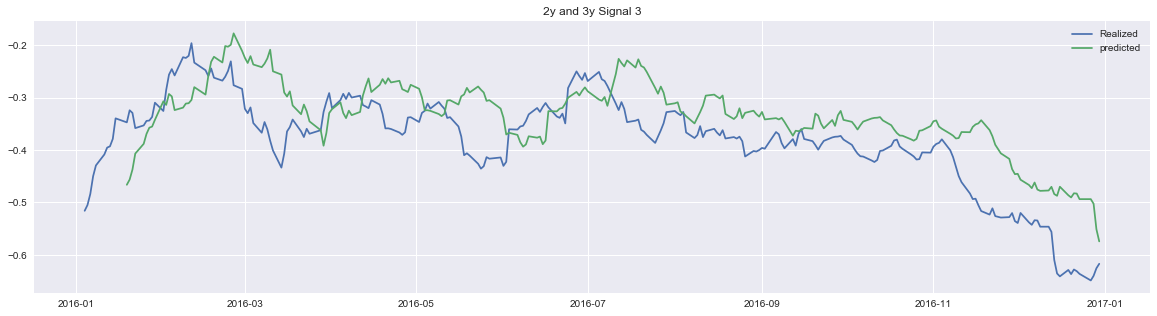

In [85]:
predict_plot(s31_C,'2y and 3y Signal 3')

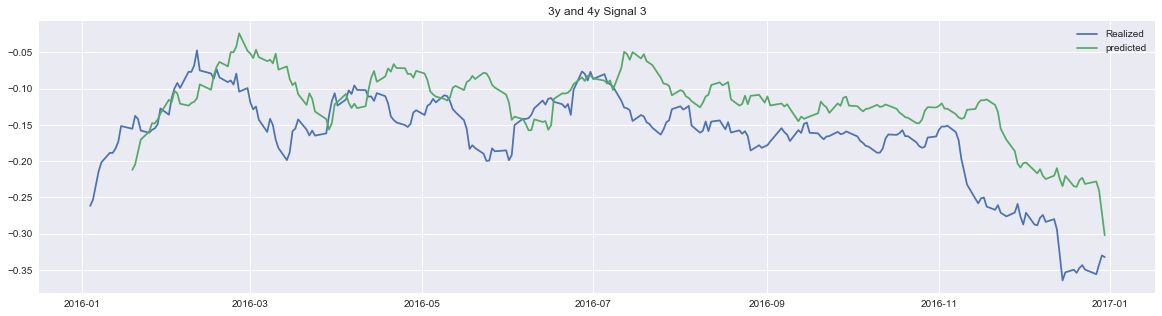

In [86]:
predict_plot(s32_C,'3y and 4y Signal 3')

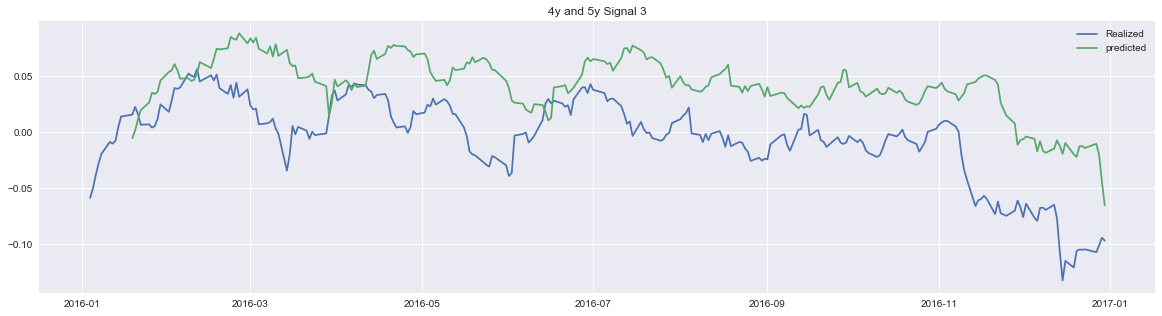

In [87]:
predict_plot(s33_C,'4y and 5y Signal 3')

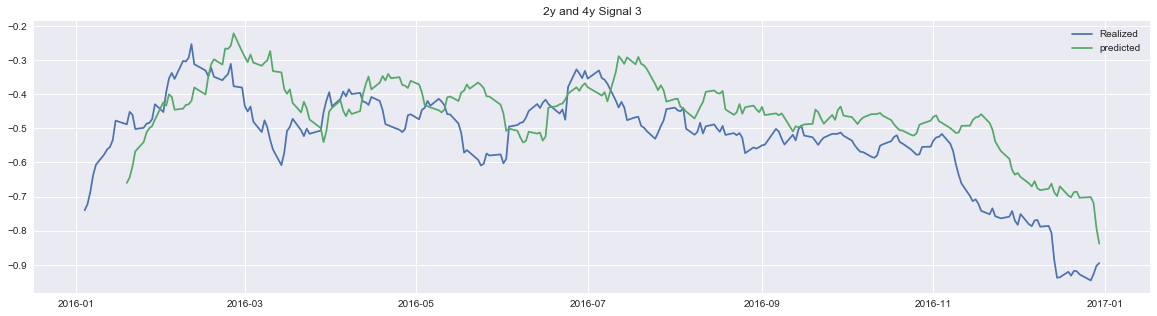

In [88]:
predict_plot(s34_C,'2y and 4y Signal 3')

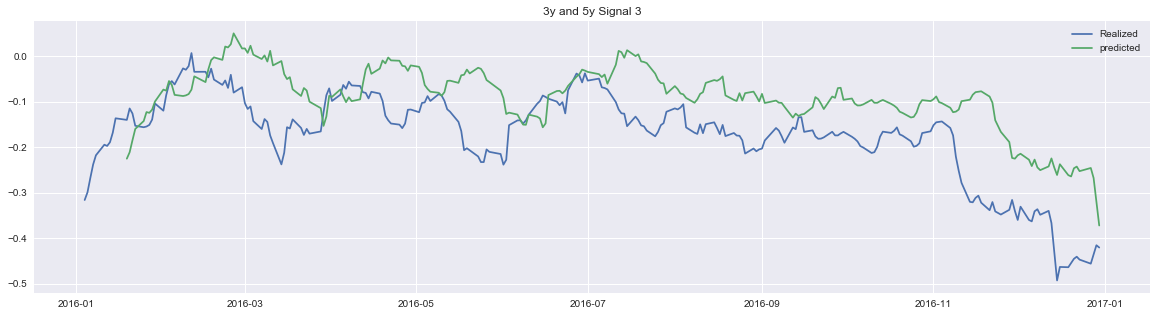

In [89]:
predict_plot(s35_C,'3y and 5y Signal 3')

#### Correlation in 4 quarters

In [90]:
print('The correlation of predicted and realized for 2y and 3y Signal 3 in quarter 1 is',np.round(correlation(s31_C[q1[0]:q1[1]]),2))
print('The correlation of predicted and realized for 3y and 4y Signal 3 in quarter 1 is',np.round(correlation(s32_C[q1[0]:q1[1]]),2))
print('The correlation of predicted and realized for 4y and 5y Signal 3 in quarter 1 is',np.round(correlation(s33_C[q1[0]:q1[1]]),2))
print('The correlation of predicted and realized for 2y and 4y Signal 3 in quarter 1 is',np.round(correlation(s34_C[q1[0]:q1[1]]),2))
print('The correlation of predicted and realized for 3y and 5y Signal 3 in quarter 1 is',np.round(correlation(s35_C[q1[0]:q1[1]]),2))

The correlation of predicted and realized for 2y and 3y Signal 3 in quarter 1 is 0.2
The correlation of predicted and realized for 3y and 4y Signal 3 in quarter 1 is 0.21
The correlation of predicted and realized for 4y and 5y Signal 3 in quarter 1 is 0.14
The correlation of predicted and realized for 2y and 4y Signal 3 in quarter 1 is 0.2
The correlation of predicted and realized for 3y and 5y Signal 3 in quarter 1 is 0.16


In [91]:
print('The correlation of predicted and realized for 2y and 3y Signal 3 in quarter 2 is',np.round(correlation(s31_C[q2[0]:q2[1]]),2))
print('The correlation of predicted and realized for 3y and 4y Signal 3 in quarter 2 is',np.round(correlation(s32_C[q2[0]:q2[1]]),2))
print('The correlation of predicted and realized for 4y and 5y Signal 3 in quarter 2 is',np.round(correlation(s33_C[q2[0]:q2[1]]),2))
print('The correlation of predicted and realized for 2y and 4y Signal 3 in quarter 2 is',np.round(correlation(s34_C[q2[0]:q2[1]]),2))
print('The correlation of predicted and realized for 3y and 5y Signal 3 in quarter 2 is',np.round(correlation(s35_C[q2[0]:q2[1]]),2))

The correlation of predicted and realized for 2y and 3y Signal 3 in quarter 2 is -0.06
The correlation of predicted and realized for 3y and 4y Signal 3 in quarter 2 is -0.08
The correlation of predicted and realized for 4y and 5y Signal 3 in quarter 2 is 0.02
The correlation of predicted and realized for 2y and 4y Signal 3 in quarter 2 is -0.07
The correlation of predicted and realized for 3y and 5y Signal 3 in quarter 2 is -0.07


In [92]:
print('The correlation of predicted and realized for 2y and 3y Signal 3 in quarter 3 is',np.round(correlation(s31_C[q3[0]:q3[1]]),2))
print('The correlation of predicted and realized for 3y and 4y Signal 3 in quarter 3 is',np.round(correlation(s32_C[q3[0]:q3[1]]),2))
print('The correlation of predicted and realized for 4y and 5y Signal 3 in quarter 3 is',np.round(correlation(s33_C[q3[0]:q3[1]]),2))
print('The correlation of predicted and realized for 2y and 4y Signal 3 in quarter 3 is',np.round(correlation(s34_C[q3[0]:q3[1]]),2))
print('The correlation of predicted and realized for 3y and 5y Signal 3 in quarter 3 is',np.round(correlation(s35_C[q3[0]:q3[1]]),2))

The correlation of predicted and realized for 2y and 3y Signal 3 in quarter 3 is 0.4
The correlation of predicted and realized for 3y and 4y Signal 3 in quarter 3 is 0.38
The correlation of predicted and realized for 4y and 5y Signal 3 in quarter 3 is 0.06
The correlation of predicted and realized for 2y and 4y Signal 3 in quarter 3 is 0.4
The correlation of predicted and realized for 3y and 5y Signal 3 in quarter 3 is 0.22


In [93]:
print('The correlation of predicted and realized for 2y and 3y Signal 3 in quarter 4 is',np.round(correlation(s31_C[q4[0]:q4[1]]),2))
print('The correlation of predicted and realized for 3y and 4y Signal 3 in quarter 4 is',np.round(correlation(s32_C[q4[0]:q4[1]]),2))
print('The correlation of predicted and realized for 4y and 5y Signal 3 in quarter 4 is',np.round(correlation(s33_C[q4[0]:q4[1]]),2))
print('The correlation of predicted and realized for 2y and 4y Signal 3 in quarter 4 is',np.round(correlation(s34_C[q4[0]:q4[1]]),2))
print('The correlation of predicted and realized for 3y and 5y Signal 3 in quarter 4 is',np.round(correlation(s35_C[q4[0]:q4[1]]),2))

The correlation of predicted and realized for 2y and 3y Signal 3 in quarter 4 is 0.85
The correlation of predicted and realized for 3y and 4y Signal 3 in quarter 4 is 0.82
The correlation of predicted and realized for 4y and 5y Signal 3 in quarter 4 is 0.72
The correlation of predicted and realized for 2y and 4y Signal 3 in quarter 4 is 0.84
The correlation of predicted and realized for 3y and 5y Signal 3 in quarter 4 is 0.77


#### RMSE in 4 quarters

In [94]:
print('The RMSE of predicted and realized for 2y and 3y Signal 3 in quarter 1 is',np.round(RMSE(s31_C[q1[0]:q1[1]]),5))
print('The RMSE of predicted and realized for 3y and 4y Signal 3 in quarter 1 is',np.round(RMSE(s32_C[q1[0]:q1[1]]),5))
print('The RMSE of predicted and realized for 4y and 5y Signal 3 in quarter 1 is',np.round(RMSE(s33_C[q1[0]:q1[1]]),5))
print('The RMSE of predicted and realized for 2y and 4y Signal 3 in quarter 1 is',np.round(RMSE(s34_C[q1[0]:q1[1]]),5))
print('The RMSE of predicted and realized for 3y and 5y Signal 3 in quarter 1 is',np.round(RMSE(s35_C[q1[0]:q1[1]]),5))

The RMSE of predicted and realized for 2y and 3y Signal 3 in quarter 1 is 0.02671
The RMSE of predicted and realized for 3y and 4y Signal 3 in quarter 1 is 0.02949
The RMSE of predicted and realized for 4y and 5y Signal 3 in quarter 1 is 0.03409
The RMSE of predicted and realized for 2y and 4y Signal 3 in quarter 1 is 0.04403
The RMSE of predicted and realized for 3y and 5y Signal 3 in quarter 1 is 0.05552


In [95]:
print('The RMSE of predicted and realized for 2y and 3y Signal 3 in quarter 2 is',np.round(RMSE(s31_C[q2[0]:q2[1]]),5))
print('The RMSE of predicted and realized for 3y and 4y Signal 3 in quarter 2 is',np.round(RMSE(s32_C[q2[0]:q2[1]]),5))
print('The RMSE of predicted and realized for 4y and 5y Signal 3 in quarter 2 is',np.round(RMSE(s33_C[q2[0]:q2[1]]),5))
print('The RMSE of predicted and realized for 2y and 4y Signal 3 in quarter 2 is',np.round(RMSE(s34_C[q2[0]:q2[1]]),5))
print('The RMSE of predicted and realized for 3y and 5y Signal 3 in quarter 2 is',np.round(RMSE(s35_C[q2[0]:q2[1]]),5))

The RMSE of predicted and realized for 2y and 3y Signal 3 in quarter 2 is 0.03136
The RMSE of predicted and realized for 3y and 4y Signal 3 in quarter 2 is 0.03215
The RMSE of predicted and realized for 4y and 5y Signal 3 in quarter 2 is 0.03771
The RMSE of predicted and realized for 2y and 4y Signal 3 in quarter 2 is 0.05038
The RMSE of predicted and realized for 3y and 5y Signal 3 in quarter 2 is 0.0614


In [96]:
print('The RMSE of predicted and realized for 2y and 3y Signal 3 in quarter 3 is',np.round(RMSE(s31_C[q3[0]:q3[1]]),5))
print('The RMSE of predicted and realized for 3y and 4y Signal 3 in quarter 3 is',np.round(RMSE(s32_C[q3[0]:q3[1]]),5))
print('The RMSE of predicted and realized for 4y and 5y Signal 3 in quarter 3 is',np.round(RMSE(s33_C[q3[0]:q3[1]]),5))
print('The RMSE of predicted and realized for 2y and 4y Signal 3 in quarter 3 is',np.round(RMSE(s34_C[q3[0]:q3[1]]),5))
print('The RMSE of predicted and realized for 3y and 5y Signal 3 in quarter 3 is',np.round(RMSE(s35_C[q3[0]:q3[1]]),5))

The RMSE of predicted and realized for 2y and 3y Signal 3 in quarter 3 is 0.03217
The RMSE of predicted and realized for 3y and 4y Signal 3 in quarter 3 is 0.03308
The RMSE of predicted and realized for 4y and 5y Signal 3 in quarter 3 is 0.03891
The RMSE of predicted and realized for 2y and 4y Signal 3 in quarter 3 is 0.05157
The RMSE of predicted and realized for 3y and 5y Signal 3 in quarter 3 is 0.06331


In [97]:
print('The RMSE of predicted and realized for 2y and 3y Signal 3 in quarter 4 is',np.round(RMSE(s31_C[q4[0]:q4[1]]),5))
print('The RMSE of predicted and realized for 3y and 4y Signal 3 in quarter 4 is',np.round(RMSE(s32_C[q4[0]:q4[1]]),5))
print('The RMSE of predicted and realized for 4y and 5y Signal 3 in quarter 4 is',np.round(RMSE(s33_C[q4[0]:q4[1]]),5))
print('The RMSE of predicted and realized for 2y and 4y Signal 3 in quarter 4 is',np.round(RMSE(s34_C[q4[0]:q4[1]]),5))
print('The RMSE of predicted and realized for 3y and 5y Signal 3 in quarter 4 is',np.round(RMSE(s35_C[q4[0]:q4[1]]),5))

The RMSE of predicted and realized for 2y and 3y Signal 3 in quarter 4 is 0.04156
The RMSE of predicted and realized for 3y and 4y Signal 3 in quarter 4 is 0.04167
The RMSE of predicted and realized for 4y and 5y Signal 3 in quarter 4 is 0.04543
The RMSE of predicted and realized for 2y and 4y Signal 3 in quarter 4 is 0.06691
The RMSE of predicted and realized for 3y and 5y Signal 3 in quarter 4 is 0.0782


#### Analyze Results

**1.Comparison among signals**
* The signal 1 forecast is very sensetive to the signal 1, which means the forecast has lags.
* The signal 2 forecast is very stable with low volatility.
* The signal 3 forecast is the linear combination of signal 1 and 2, so it intakes the two signals characteristics.  

**2.Comparison from quarter to quarter**
* The forecast is not stable from quarter to quarter, and the combined signal - signal 3 does not display its forecast power, still very weak from quality metrics.
* Since all realized signals in quarter 2 are very mean-reverting, the forecast shows negative correlation with the realized signals. The result still shows that all signals are poor to forecast.
* Signal 1 and 3 are trending in quarter 4, so the forecast shows high positive correlation with the realized signals.

**3.Possible problems and improvements**  
* For all signals, the forecast is based on static AR parameters, which are determined from Sample A. We can try to fit dynamic AR parameters for forecasting.
* For signal 3, the theta is also static. A possible improvement is to change it as dynamic.